#### Library import

In [256]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [257]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [258]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [259]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6041751694488968741
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3251140996209585769
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [260]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [261]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [262]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [263]:
As = data
Cd = data
Ni = data

In [264]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [265]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [266]:
import smogn

In [267]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'balance', k = 10)
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'balance', k = 10)
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'balance', k = 10)

dist_matrix:   0%|          | 1/248 [00:00<00:27,  9.09it/s]

r_index: 100%|##########| 3/3 [00:00<00:00, 499.72it/s]


In [268]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1210, 16)
(1198, 16)
(1216, 16)


#### Eliminate outlier and train / test split

In [269]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [270]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [271]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [272]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [273]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(978, 15)
(1041, 15)
(1155, 15)


StandardScaler

In [274]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [275]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\n\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [276]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [277]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(782, 15)
(832, 15)
(924, 15)


#### 10-Fold Crossvalidation

In [278]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [279]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [280]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [281]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-27 23:02:43,751] A new study created in memory with name: rf_parameter_opt
[I 2023-08-27 23:02:44,963] Trial 0 finished with value: 0.3405599374932361 and parameters: {'n_estimators': 76, 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 12}. Best is trial 0 with value: 0.3405599374932361.
[I 2023-08-27 23:02:45,308] Trial 1 finished with value: 0.37857930652149585 and parameters: {'n_estimators': 16, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 18}. Best is trial 1 with value: 0.37857930652149585.
[I 2023-08-27 23:02:46,799] Trial 2 finished with value: 0.3545229347114067 and parameters: {'n_estimators': 93, 'max_depth': 4, 'min_samples_leaf': 12, 'min_samples_split': 3}. Best is trial 1 with value: 0.37857930652149585.
[I 2023-08-27 23:02:47,376] Trial 3 finished with value: 0.37232106013236177 and parameters: {'n_estimators': 32, 'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 9}. Best is trial 1 with value: 0.37857930652149585.
[I 2

Best r2:  0.44589696913250226
Best trial: {'n_estimators': 94, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [282]:
optuna.visualization.plot_parallel_coordinate(study)

In [283]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 94, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [284]:
study.best_trial.params["n_estimators"]

94

In [285]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=94, random_state=42)

In [286]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [287]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [288]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.3181260015935225
Test RMSE:  0.8197445103992506


In [289]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.8556163348947956
Test R2:  0.08203834127670961


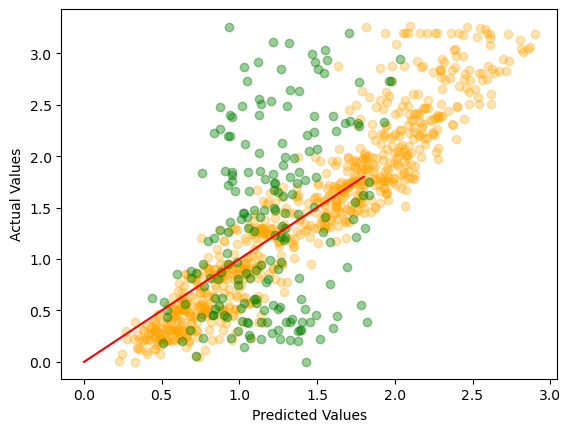

In [290]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [291]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-27 23:06:10,785] A new study created in memory with name: rf_parameter_opt
[I 2023-08-27 23:06:12,132] Trial 0 finished with value: 0.5229196461742349 and parameters: {'n_estimators': 56, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 0 with value: 0.5229196461742349.
[I 2023-08-27 23:06:13,849] Trial 1 finished with value: 0.5047444455874099 and parameters: {'n_estimators': 79, 'max_depth': 9, 'min_samples_leaf': 11, 'min_samples_split': 6}. Best is trial 0 with value: 0.5229196461742349.
[I 2023-08-27 23:06:14,454] Trial 2 finished with value: 0.24220885373415624 and parameters: {'n_estimators': 76, 'max_depth': 1, 'min_samples_leaf': 12, 'min_samples_split': 16}. Best is trial 0 with value: 0.5229196461742349.
[I 2023-08-27 23:06:16,215] Trial 3 finished with value: 0.49591863233900624 and parameters: {'n_estimators': 87, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.5229196461742349.
[I 2023

Best r2:  0.5416755901533735
Best trial: {'n_estimators': 98, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}


In [292]:
optuna.visualization.plot_parallel_coordinate(study)

In [293]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 98, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}


98

In [294]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=98, random_state=42)

In [295]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [296]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.0865729370012153
Test RMSE:  0.15230895702715214


In [297]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.8409878893441753
Test R2:  0.428371845297536


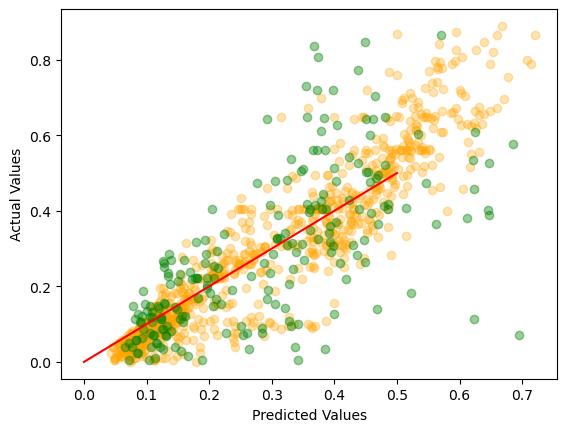

In [298]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [299]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-27 23:08:59,734] A new study created in memory with name: rf_parameter_opt
[I 2023-08-27 23:09:00,615] Trial 0 finished with value: 0.4653532998638146 and parameters: {'n_estimators': 37, 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 11}. Best is trial 0 with value: 0.4653532998638146.
[I 2023-08-27 23:09:01,031] Trial 1 finished with value: 0.4806133644848273 and parameters: {'n_estimators': 15, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 19}. Best is trial 1 with value: 0.4806133644848273.
[I 2023-08-27 23:09:02,796] Trial 2 finished with value: 0.5332453836805209 and parameters: {'n_estimators': 63, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 12}. Best is trial 2 with value: 0.5332453836805209.
[I 2023-08-27 23:09:03,044] Trial 3 finished with value: 0.3096520777492507 and parameters: {'n_estimators': 15, 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 17}. Best is trial 2 with value: 0.5332453836805209.
[I 2023-0

Best r2:  0.5958961904997604
Best trial: {'n_estimators': 69, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [300]:
optuna.visualization.plot_parallel_coordinate(study)

In [301]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 69, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


69

In [302]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=69,
                      random_state=42)

In [303]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [304]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.3510505602889888
Test RMSE:  0.9370122635663368


In [305]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9145687368228386
Test R2:  0.36757546523559126


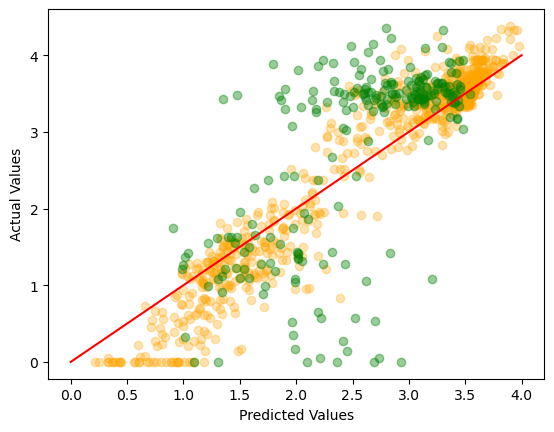

In [306]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()